In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Learning Simulations
These are my notes for going through the excercises in the neuronal dynamics textbook.


In [3]:
# Import brian
from brian2 import *
# data frame support and `tidy` plotting
import pandas as pd
import numpy as np
# ggplot port to python
from plotnine import *
#activate inline use of matplotlib
%matplotlib inline

Define a very simple neuron with this syntax.
The text in the apostrophe environment are the differential equations that define the behaviour.


In [4]:
tau = 10*ms             # a time constant
eqs = '''
dv/dt = (1-v)/tau : 1
'''

Now we can put the equation into a neuron.
The equation formally typed out:
\begin{equation}
\frac{\partial v}{\partial t} = \frac{(1-v)}{\tau}
\end{equation}
This equation is a simple exponential decay with $\tau$ time constant.

\begin{equation}
v(t) = 1-\exp\left(\frac{-t}{\tau}\right)
\end{equation}

## Simulating and plotting from a single Neuron
Next we assign a Neuron with that voltage equation.
Neurons are always assigned as a neuron group.

In [5]:
G = NeuronGroup(1, eqs)

Now we can simulate the timecourse with the run command.

In [6]:
start_scope()

run(100*ms)

Next, we would like to simulate and look at different aspects of the model as it evolves in time.
Variables of the model at a given point in time are referred to as *states* by brian.
The following block simulates and records the time course of voltage based on the model (it should just be an exponential asymptote to 1)



In [7]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=0)

run(30*ms)

# plot(M.t/ms, M.v[0])
# xlabel('Time (ms)')
# ylabel('v');

State monitor objects are used to store the information of a run.
The neurons have to be specified (here: `record = 0` option) in order to preserve memory.

Now we can introduce spiking behaviour.
Whenever the threshold is reached, voltage gets set to 0, and decays with the defined equation.
These can both be specified in the neuron specification.

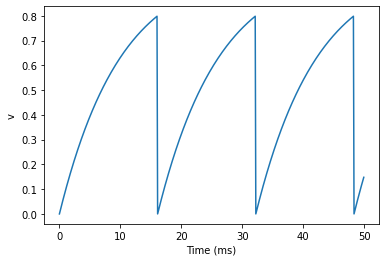

In [8]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(2, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

`StateMonitor` are 2D arrays with the index of the neuron, and the value of the timecourse.
This *should* lend itself to create tidy dataframes from this.
It can be done with the `get.states` syntax (requires pandas).

In [9]:
simdata = pd.DataFrame({
    'N': len(M.v),
    't': M.t,
    'V': M.v[0]})


This produces the output I want from this one, but is not quite what I want yet, we can go back to it.
Want to have a tidy format dataframe generated from a `StateMonitor` call that can handle multiple variables and neurons.
Should be doable with for loops.

Pseudocode:

* For each neuron in number_neurons
    - do a call to get states that produces a tidy output for that neuron
* then append these tidy frames to each other with a neuron index variable
* assign that to the main environment

Plotnine is the graphing library that should come close to functionaity to ggplot and has a tidy working paradigm.
Try to explore the tidy set created and make a line plot.

This should also be possible with np reshape commands.

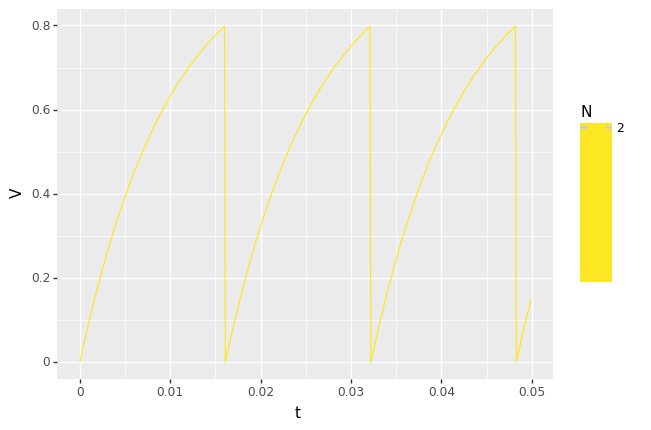

<ggplot: (8773402052139)>

In [10]:
(ggplot(simdata, aes(x = 't', y = 'V', colour = 'N'))
+ geom_line())

Brian can register spikes in the simulation.
This has been done by assigning the spike monitor command.

In [11]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.4', reset='v = 0.2', method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

# update the simdataframe 
simdata = pd.DataFrame({
    'N': len(statemon.v),
    't': statemon.t,
    'V': statemon.v[0]})

In [12]:
print('Spike times: %s' % spikemon.t[:])

Spike times: [ 5.1  8.  10.9 13.8 16.7 19.6 22.5 25.4 28.3 31.2 34.1 37.  39.9 42.8
 45.7 48.6] ms


In [13]:
spikesdf = pd.DataFrame({'spikes': spikemon.t/ms /1000})

Now we can plot the extracted spikes, on top of the timecourse.


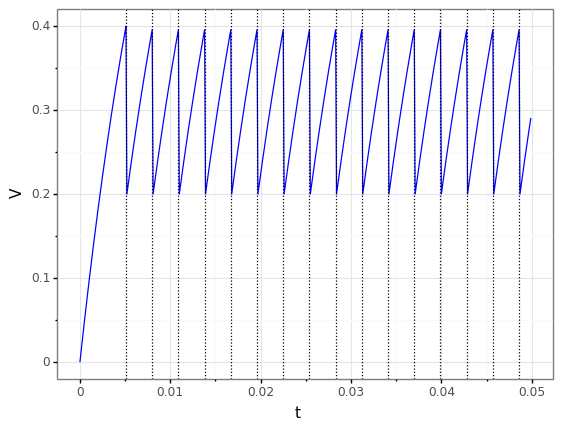

<ggplot: (8773401987676)>

In [14]:
(ggplot(simdata, aes(x = 't', y = 'V'))
+ geom_line(colour = 'blue')
+ geom_vline(aes(xintercept = 'spikes'), data = spikesdf, linetype = 'dotted')
+ theme_bw())

You can introduce refractoryness to the model by adding a refractory dead time.

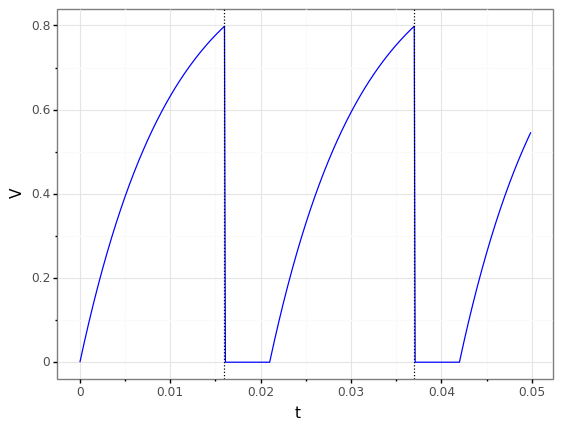

<ggplot: (-9223363263448933365)>

In [15]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

# The neuron with refractory time
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

# update the simdataframe 
simdata = pd.DataFrame({
    'N': len(statemon.v),
    't': statemon.t,
    'V': statemon.v[0]})

# update the spikes
spikesdf = pd.DataFrame({'spikes': spikemon.t/ms /1000})

# plot it
(ggplot(simdata, aes(x = 't', y = 'V'))
+ geom_line(colour = 'blue')
+ geom_vline(aes(xintercept = 'spikes'), data = spikesdf, linetype = 'dotted')
+ theme_bw())

What I did not like about the `plotnine` is that its ggpleot implementation seems to be very sensitive about types and spazzes out immediatly on that, whereas usually R will just throw a warning about continous vs other data.

Altair is another plotting library that looks very clean and is also ignorant about types.

In [16]:
import altair as alt

#tc plot
tc_chart = alt.Chart(simdata).mark_line().encode(
    x = 't:Q', 
    y = 'V:Q'  # Quantitative variable
)

#plot of the spike value with vertical line
spike_chart = alt.Chart(spikesdf).mark_rule(strokeDash=[5,5]).encode(
    x = 'spikes:Q'
)

# combine and print
alt.layer(tc_chart,spike_chart)

alt.LayerChart(...)

While not as straightforward as ggplot the syntax and output is simple and prety enough.

## Simulating multiple Neurons

Next are going to produce ouput for many neuron.

In [17]:
start_scope()
n_neurons = 100         # Number of neurons
tau = 10*ms             # time constant

# same equation as before but the asymtone is now 2
eqs = '''          
dv/dt = (2-v)/tau : 1 
''' 
# A network of 100 neurons
net_100 = NeuronGroup(n_neurons, eqs, threshold='v>1', reset='v=0', method='exact')
# this gives every neuron a different starting value for the voltage at t0
net_100.v = 'rand()' 

spikemon = SpikeMonitor(net_100) # this records the spiketimes

run(50*ms)


Now we need to clean the spikemonitor variable.
It contains variables `i` (neuron index) and `t` (spiketime).
They are arrays containing just one vector (dimension `(n_spikes,)`) and have the same length.
Tidying should therefore be easy.

There is a method implemented for `SpikeMonitor` objects that will return a dictionary object of the values, with the umber of the neuron as index.
Problem is it produces an array with a unit.

In [18]:
spikemon.all_values()['t'][0]

array([ 8.7, 36.7,  1.7, 29.7, 15.7, 43.7, 22.7]) * msecond

Despite this, pandas allows import, however, the data is now in wide format with the neuron as rows.
So we need to do some wrangling and pivoting.

In [19]:
spikes_wide = pd.DataFrame.\
from_dict(spikemon.all_values()['t'],
          orient = 'index')

# pandas for some reason loves rownames, which pisses me off coming from R
# we need to get the information stored in there!
spikes_wide.index.name = 'neuron'
spikes_wide.reset_index(inplace=True)

# pivot longer by neuron
spikes_long = spikes_wide.melt(id_vars = ('neuron'),
                               value_vars = list(range(0,8)),
                               var_name = 'spikeno',
                               value_name = 't')
# tidy and update the thing
spikes_long = spikes_long.sort_values(['neuron', 'spikeno'])
# drop NA values
spikes_long = spikes_long.dropna()
spikes_long

,neuron,spikeno,t
0,0,0,8.7 ms
100,0,1,36.7 ms
200,0,2,1.7 ms
300,0,3,29.7 ms
400,0,4,15.7 ms
...,...,...,...
299,99,2,2. ms
399,99,3,30. ms
499,99,4,44. ms
599,99,5,9. ms


This looks fine, but trying to wrangle more I got massive problems because the data types are rubbish.

In [20]:
spikes_long.dtypes

neuron      int64
spikeno    object
t          object
dtype: object

In [21]:
spikes_long['t'].str.split(expand = True)

,0
0,NaN
100,NaN
200,NaN
300,NaN
400,NaN
...,...
299,NaN
399,NaN
499,NaN
599,NaN


My plan was to treat the compound unt datatype as string and then extract the actual number.
That does not work and throws an error.
To get the number I need to apply the `/ms` syntax from the unit data type from brian.
That works only in a vectorised way if you have a numpy array.
Now it all lives in pandas.
We can do it on an individual datum though.


In [22]:
spikes_long['t'][1]


26.5 * msecond

In [23]:
spikes_long['t'][1]/ms


26.500000000000004

In [24]:
#vectorised is gets rid of something but not quite...
spikes_long['t']/ms

0       8.7 s
100    36.7 s
200     1.7 s
300    29.7 s
400    15.7 s
        ...  
299      2. s
399     30. s
499     44. s
599      9. s
699     23. s
Name: t, Length: 711, dtype: object

In [25]:
# try assiging a new column (mutate style in R)
spikes_long.assign(spiket = spikes_long['t'] /ms)

,neuron,spikeno,t,spiket
0,0,0,8.7 ms,8.7 s
100,0,1,36.7 ms,36.7 s
200,0,2,1.7 ms,1.7 s
300,0,3,29.7 ms,29.7 s
400,0,4,15.7 ms,15.7 s
...,...,...,...,...
299,99,2,2. ms,2. s
399,99,3,30. ms,30. s
499,99,4,44. ms,44. s
599,99,5,9. ms,9. s


It does not work, we need to do it row-wise!
Row-wise operations can be done with apply.

In [26]:
spikes_long['t'].apply(lambda x: x/ms)

0       8.7
100    36.7
200     1.7
300    29.7
400    15.7
       ... 
299     2.0
399    30.0
499    44.0
599     9.0
699    23.0
Name: t, Length: 711, dtype: float64

In [27]:
# do that in place
spikes_long['tnum'] = spikes_long['t'].apply(lambda x: x/ms)

Now we should be able to plot the spiketimes from the frame.


In [28]:
alt.Chart(spikes_long)\
.mark_point()\
.encode(x = 'tnum', y = 'neuron:Q')

alt.Chart(...)

Also altair lets us plot the thing even without transforming the type before as long as you specify that its a quantitative variable (`:Q` tag).

In [29]:
alt.Chart(spikes_long)\
.mark_point()\
.encode(x = 't:Q', y = 'neuron:Q')

alt.Chart(...)

## Parameters
We can systematically vary input parameter along neurons.

In [30]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

The line `v0 : 1` declares a new per-neuron parameter `v0` with units 1 (i.e. dimensionless) for the asymptote of the exponential.
The line `G.v0 = 'i*v0_max/(N-1)'` initialises the value of v0 for each neuron varying from 0 up to `v0_max`. The symbol `i` when it appears in strings like this refers to the neuron index.

In [31]:
# now we can run this and extract the spikes
run(duration)

In [32]:
spikes_wide = pd.DataFrame.\
from_dict(M.all_values()['t'],
          orient = 'index')

# pandas for some reason loves rownames, which pisses me off coming from R
# we need to get the information stored in there!
spikes_wide.index.name = 'neuron'
spikes_wide.reset_index(inplace=True)
# there will be now 1 neuron column with number of neuron rows
# and a column for each spike (as many columns as the maximum number of spikes for a neuron)
# there is an index column and a neuron column, so the max number of spikes
# and the number of data colums is the number of columns -2
spike_max = spikes_wide.shape[1]

# pivot longer by neuron
spikes_long = spikes_wide.melt(id_vars = ('neuron'),
                               value_vars = list(range(0,spike_max-1)),
                               var_name = 'spikeno',
                               value_name = 't')
# tidy and update the thing
spikes_long = spikes_long.sort_values(['neuron', 'spikeno'])
# drop NA values
spikes_long = spikes_long.dropna()
spikes_long['t'] = spikes_long['t'].apply(lambda x: x/ms)

In [108]:
# make this procedure into a function
def tidy_spike(s_mon_object) :
    """
    This function takes all the data from within a spikemonitor brian object
    and makes it into a tidy pandas frame
    """
    # extract the data to a wide frame
    sdata_wide =  pd.DataFrame.from_dict(s_mon_object.all_values()['t'],orient = 'index')
    sdata_wide.index.name = 'neuron'
    sdata_wide.reset_index(inplace=True)
    # there will be now 1 neuron column with number of neuron rows
    # and a column for each spike (as many columns as the maximum number of spikes for a neuron)
    # there is an index column and a neuron column, so the max number of spikes
    # and the number of data colums is the number of columns -2
    spike_max = sdata_wide.shape[1]
    
    # pivot longer by neuron
    sdata_long = sdata_wide.melt(id_vars = ('neuron'),
                               value_vars = list(range(0,spike_max-1)),
                               var_name = 'spikeno',
                               value_name = 't')
    
    # tidy and update the thing
    sdata_long = sdata_long.sort_values(['neuron', 'spikeno'])
    # drop NA values
    sdata_long = sdata_long.dropna()
    # add a proper numeric time variable
    sdata_long['t_ms'] = sdata_long['t'].apply(lambda x: x/ms)
    
    #return the thing
    return(sdata_long)  

In [109]:
# test the function
tidy_spike(M)

,neuron,spikeno,t,t_ms
18,18,0,0.4036 s,403.6
20,20,0,0.9031 s,903.1
120,20,1,125.5 ms,125.5
220,20,2,0.7287 s,728.7
21,21,0,74.2 ms,74.2
...,...,...,...,...
10799,99,107,203.1 ms,203.1
10899,99,108,0.6773 s,677.3
10999,99,109,192.8 ms,192.8
11099,99,110,230.3 ms,230.3


In [35]:
# now plot the thing
alt.Chart(spikes_long)\
.mark_point()\
.encode(x = 't:Q',
       y = 'neuron')


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

So apparently altair refuses to make plots with "large" datasets, which actually makes it utterly useless.

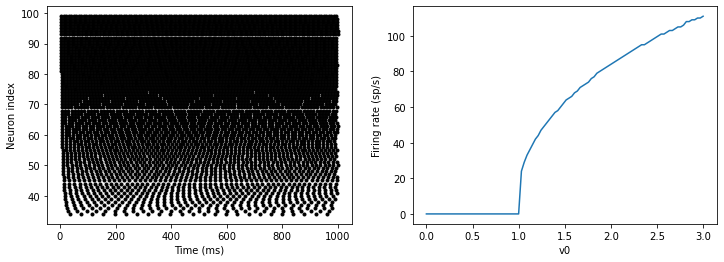

In [36]:
figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

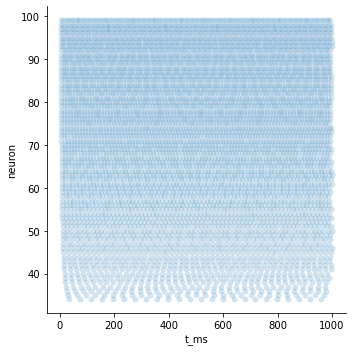

In [37]:
# try seaborn instead
import seaborn as sns

sns.relplot(x="t_ms", y="neuron", data=tidy_spike(M), alpha = 0.2);

Next, try to reproduce the plot from the example.
We will need to summarise by neuron to get the firing rate.
This should be possible with some group wise-pandas operation.
The syntax for this is `groupby` and `agg`. 

In [38]:
tidy_spike(M).groupby('neuron').agg({'spikeno': [max]})

,spikeno
,max
neuron,
34,23
35,28
36,32
37,35
38,38
...,...
95,108
96,108


This will give rubbish again because python indexes with 0.
In a world of meaningful numbers we need to add 1 to it to make it right.
After the summary we need to run some in-place mutation to add 1 to the the max spike.

In [39]:
summary_byN = tidy_spike(M).groupby('neuron').agg({'spikeno': [max]})
# add 1
summary_byN = summary_byN.assign(APMAX = summary_byN['spikeno']+1)
# calculate the firing rate (we simulated 1 second)
summary_byN = summary_byN.assign(FRate_hz = summary_byN['spikeno']/1)


Inspecting the code of the matplotlib stuff, there is actually by neuron summaries stored in the G and M objects.
Better try to write a tidier for those instead of re-inventing.

In [40]:
# firing counts
pd.Series({'A': np.array(M.count)})

A    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object

Also `brian` has a method to extract the neuron parameters in pandas format to start.

In [41]:
# extracts all the model starting parameters and the last timepoint
summary_byN = G.get_states(units=False, format='pandas') 
# now we can assign the firing rate data as new columns
summary_byN['nAP'] = pd.Series(np.array(M.count))
# calculate firing rate
summary_byN = summary_byN.assign(FRate_hz = summary_byN['nAP']/1)
summary_byN

,N,i,t,dt,t_in_timesteps,v,lastspike,not_refractory,v0,nAP,FRate_hz
0,100,0,1.0,0.0001,10000,0.000000,-10000.0000,True,0.000000,0,0.0
1,100,1,1.0,0.0001,10000,0.030303,-10000.0000,True,0.030303,0,0.0
2,100,2,1.0,0.0001,10000,0.060606,-10000.0000,True,0.060606,0,0.0
3,100,3,1.0,0.0001,10000,0.090909,-10000.0000,True,0.090909,0,0.0
4,100,4,1.0,0.0001,10000,0.121212,-10000.0000,True,0.121212,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95,100,95,1.0,0.0001,10000,0.000000,0.9978,False,2.878788,109,109.0
96,100,96,1.0,0.0001,10000,0.000000,0.9978,False,2.909091,109,109.0
97,100,97,1.0,0.0001,10000,0.000000,0.9960,False,2.939394,110,110.0
98,100,98,1.0,0.0001,10000,0.000000,0.9960,False,2.969697,110,110.0


Now we can plot the systematically varied parameter and the firing rate.

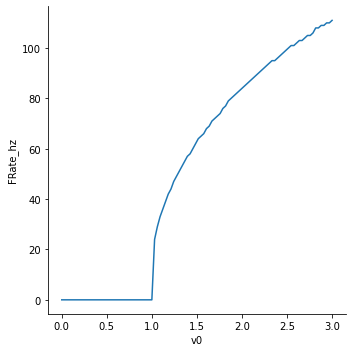

In [42]:
sns.relplot(x="v0", y="FRate_hz", data=summary_byN, kind = 'line');

To replicate what has been done in the example we need to set the plots side by side.
With seaborn that is done with matplotlib.
Seaborn is  a wrapper to matplotlib and creates plot objects compatible with it.

I had to change the options for plotting.
The previously used `relplot` is meant to produce larger facetted plots that you cant pass to make subplots apparently.

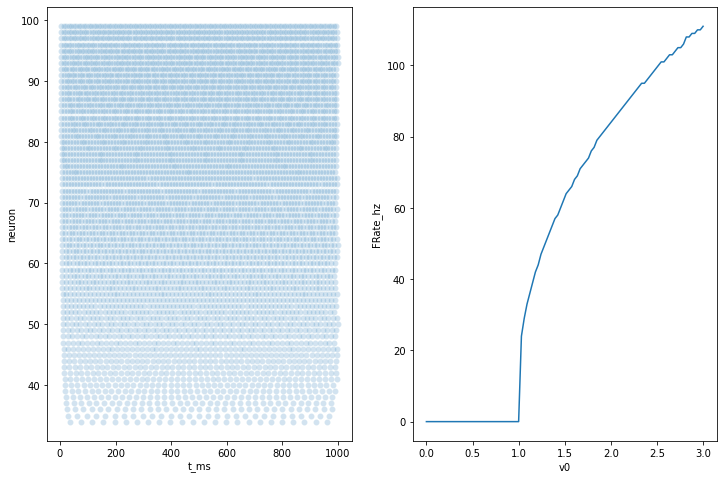

In [43]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(12, 8))
sns.scatterplot(x="t_ms", y="neuron", data=tidy_spike(M), alpha = 0.2, ax=axes[0])
sns.lineplot(x="v0", y="FRate_hz", data=summary_byN, ax=axes[1]);

### Introducing a stochastic variable

In [121]:
start_scope()

N = 100
tau = 10*ms
v0_max = 1.
duration = 2000*ms
sigma = 0.4

eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

Gnew = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
Mnew = SpikeMonitor(Gnew)

Gnew.v0 = 'i*v0_max/(N-1)'

run(duration)


This introduces a gaussian jitter on tau `sigma*xi*tau**-0.5`, why it takes this form exactly I dont know and is beyond me.

In [134]:
# Make a tidier for by neuron summaries
def tidy_byN(aneuron, monitorobj):
    """
    This function takes a brian neuron group
    and a spike monitor object of it
    then returns a tidy pandas frame of the start and and values and the firing rates
    """
    # extracts all the model starting parameters and the last timepoint
    byN = aneuron.get_states(units=False, format='pandas')
    
    # duration of the run
    run_dur = byN['t_in_timesteps'][0]*byN['dt'][0]
    # now we can assign the firing rate data as new columns
    byN['nAP'] = pd.Series(np.array(monitorobj.count))
    # calculate firing rate
    byN = byN.assign(FRate_hz = byN['nAP']/run_dur)
    return(byN)

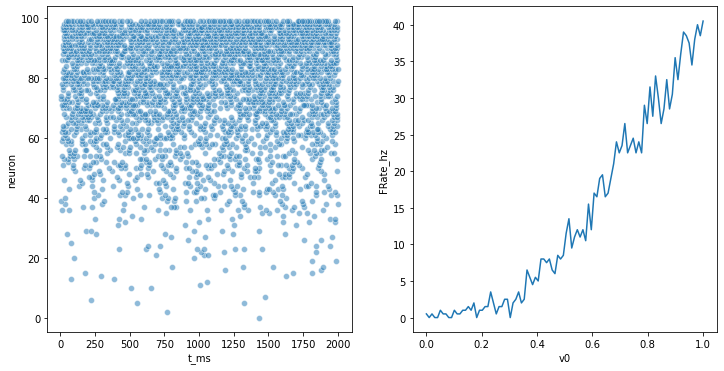

In [135]:
# now we can use both tidiers to quickly plot everything
f, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(x="v0", y="FRate_hz", data= tidy_byN(Gnew, Mnew), ax=axes[1])
sns.scatterplot(x = 't_ms', y = 'neuron', data = tidy_spike(Mnew), alpha = 0.5, ax=axes[0]);

# Synapses

In [142]:
start_scope()

eqs = '''
dv/dt = (asym-v)/tau : 1
asym : 1
taun : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.asym = [2, 0]
G.taun = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

Mstate = StateMonitor(G, 'v', record=True)

run(100*ms)

Next section in the Manual:
We create 2 neurons.
For the parameters we can assign a vector of the length of the number of neurons.
We have different values for the asymtote as well as the time constant.
The First neuron should be exiteable spontaneously, the second not at all.

However, there is a synapse on the second on which will increase `v` on every spike of the first.
It should therefore fire after integrating a couple of spikes.

Now we will need a tidier for the V monitor object.
This may be a bit more complicated.
`monitor.v` is a 2 dimensional array.
There is a row for every Neuron.

In [170]:
np.array(Mstate.v).shape

(2, 1000)

I dont know wnough about the arrays to see whether the following will fill the rows in the right way.
Got to try.

In [171]:
np.array(Mstate.v).reshape(1000,2)

array([[0.        , 0.01990033],
       [0.03960265, 0.05910893],
       [0.07842112, 0.09754115],
       ...,
       [0.34536538, 0.34192893],
       [0.33852668, 0.33515829],
       [0.33182341, 0.32852171]])

This should be a rectangular table that pandas could handle.

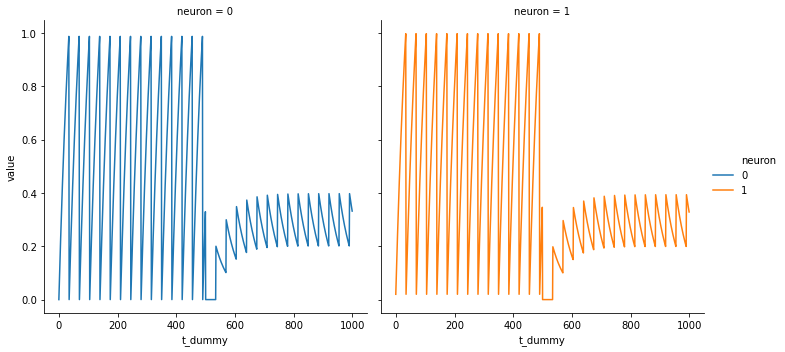

In [191]:
# If the following returns the time-series alright we are golden.
# reshape and make a frame
test = pd.DataFrame(np.array(Mstate.v).reshape(1000,2))
test.index.name = 't_dummy'
test.reset_index(inplace=True)

# make long
test = test.melt(id_vars = 't_dummy', value_vars = [0, 1], var_name = "neuron")

sns.relplot(x = 't_dummy',
            y = 'value',
            hue = "neuron",
            col = "neuron",
            kind = "line",
            data = test);

It does not and the data from the `np.reshape` was just spread between the two columns.

In [215]:
# Its stored per row so we should be able to make a frame without reshaping
# reshape and make a frame
test = pd.DataFrame(np.array(Mstate.v))
test.index.name = 'neuron'
test.reset_index(inplace=True)
test

,neuron,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,0,0.0,0.0199,0.039603,0.059109,0.078421,0.097541,0.116471,0.135212,0.153767,...,0.190325,0.208332,0.226159,0.243809,0.261284,0.278584,0.295712,0.312670,0.329460,0.346082
1,1,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.359460,0.355883,0.352342,0.348836,0.345365,0.341929,0.338527,0.335158,0.331823,0.328522


In [216]:
# make long
test = test.melt(id_vars = 'neuron')

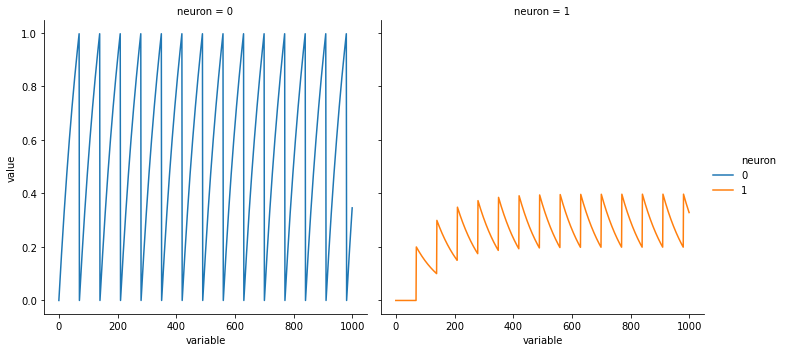

In [217]:
sns.relplot(x = 'variable',
            y = 'value',
            hue = "neuron",
            col = "neuron",
            kind = "line",
            data = test);

In [218]:
#  Try to include the time in this
# the time actually is in column format
testt = pd.DataFrame(np.array(Mstate.t)())
testt

,0
0,0.0000
1,0.0001
2,0.0002
3,0.0003
4,0.0004
...,...
995,0.0995
996,0.0996
997,0.0997
998,0.0998
